In [1]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas as pd
import xarray
import h5py
import healpy as hp
import time

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting
from ulmo.analysis import spatial_plots as sp

#### Goals: 
#### 1. Select LLC and VIIRS cutouts from two regions: in equatorial pacific and 60W shelf/confluence
#### 2. Create a side by side 9 ~ med LL image gallery for LLC and VIIRS

# Load Tables

In [2]:
llc_tbl= ulmo_io.load_main_table( 's3://llc/Tables/LLC_uniform_viirs_noise.parquet' )
llc_tbl['dT'] = llc_tbl.T90 - llc_tbl.T10
llc_tbl.head()

Read main table: s3://llc/Tables/LLC_uniform_viirs_noise.parquet


,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,pp_idx,pp_type,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms,LL,dT
0,71.725098,-177.172684,12895,10607,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,-1.467546,...,647491,0,-0.099179,-0.001986,0.059771,0.063255,0.141285,0.082805,642.516968,0.190000
1,71.747978,-175.380554,12895,10676,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,-0.492408,...,384768,0,-0.008606,-0.042140,0.041484,0.108360,0.046431,0.037870,-508.767731,4.904001
2,71.758400,-173.559555,12895,10746,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,3.271719,...,283882,0,0.070156,-0.045817,0.022577,0.044823,0.099820,0.029986,345.613159,0.958000
3,71.755905,-171.737854,12895,10816,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,2.945127,...,613023,0,0.081717,-0.010355,0.024675,0.039160,0.115622,0.034708,169.615540,1.146000
4,71.740822,-169.943695,12895,10885,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,2.364319,...,537161,0,0.039346,0.019852,0.023803,0.031211,0.057416,0.030541,343.068726,0.950000


In [3]:
viirs_tbl = ulmo_io.load_main_table( 's3://viirs/Tables/VIIRS_all_99clear_std.parquet')
viirs_tbl['dT'] = viirs_tbl.T90 - viirs_tbl.T10
viirs_tbl.head()

Read main table: s3://viirs/Tables/VIIRS_all_99clear_std.parquet


,filename,row,col,lat,lon,clear_fraction,field_size,datetime,ex_filename,pp_file,...,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,LL,Year,dT
0,s3://viirs/data/2012/048/20120217193000-OSPO-L...,720,1248,19.590923,89.338295,4.470527e-17,192,2012-02-17 19:30:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,5,0,24.843233,24.029999,25.730011,25.119995,24.510010,331.460999,2012,0.609985
1,s3://viirs/data/2012/047/20120216052000-OSPO-L...,4848,1632,-14.932406,120.176720,1.898872e-04,192,2012-02-16 05:20:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,6,0,31.347763,29.929993,31.869995,31.579987,31.119995,579.588074,2012,0.459991
2,s3://viirs/data/2012/050/20120219111000-OSPO-L...,1008,2112,-36.731842,33.399803,8.056641e-03,192,2012-02-19 11:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,9,0,22.753841,20.970001,23.489990,23.089996,22.429993,274.181274,2012,0.660004
3,s3://viirs/data/2012/201/20120719012000-OSPO-L...,48,1056,38.578500,3.368228,4.882812e-04,192,2012-07-19 01:20:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,12,0,25.789021,23.619995,26.589996,26.139984,25.420013,266.262878,2012,0.719971
4,s3://viirs/data/2012/127/20120506022000-OSPO-L...,1488,2016,44.143940,151.003390,1.220703e-03,192,2012-05-06 02:20:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,14,0,4.603452,3.470001,5.579987,5.059998,4.109985,65.829651,2012,0.950012


In [4]:
uni_tbl = ulmo_io.load_main_table( 's3://llc/Tables/test_uniform_r0.5_test.feather' )
uni_tbl['dT'] = uni_tbl.T90 - uni_tbl.T10
uni_tbl.head()

Read main table: s3://llc/Tables/test_uniform_r0.5_test.feather


,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,pp_idx,pp_type,LL,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms,dT
0,71.725098,-177.172684,12895,10607,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,-1.467546,...,647491,0,648.981934,-0.099179,-0.001986,0.059771,0.063255,0.141285,0.082805,0.190000
1,71.747978,-175.380554,12895,10676,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,-0.492408,...,384768,0,-513.771851,-0.008606,-0.042140,0.041484,0.108360,0.046431,0.037870,4.904001
2,71.758400,-173.559555,12895,10746,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,3.271719,...,283882,0,345.448669,0.070156,-0.045817,0.022577,0.044823,0.099820,0.029986,0.958000
3,71.755905,-171.737854,12895,10816,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,2.945127,...,613023,0,169.709839,0.081717,-0.010355,0.024675,0.039160,0.115622,0.034708,1.146000
4,71.740822,-169.943695,12895,10885,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,2.364319,...,537161,0,349.981262,0.039346,0.019852,0.023803,0.031211,0.057416,0.030541,0.950000


# Region 1 : Equatorial Pacific

### North : LLC

In [5]:
eqtr_n = (llc_tbl.lat > 0. ) & (np.abs(llc_tbl.lat) < 2.) & (np.abs(llc_tbl.lon + 100) < 5.)
llc_eqtr_n = llc_tbl[ eqtr_n ]

med_LL_n = np.median(llc_eqtr_n.LL.to_numpy())
med_LL_n

801.5445

In [7]:
uni_eqtr_n = uni_tbl[ eqtr_n ]

In [8]:
llc_eqtr_n.head()

,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,pp_idx,pp_type,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms,LL,dT
50116,1.789456,-104.406250,7980,14060,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.969849,...,719955,0,-0.603287,0.143694,0.124387,0.092743,0.853176,0.175910,821.077209,0.840000
50117,1.789456,-103.718750,7980,14093,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.980335,...,297462,0,-0.593994,0.139731,0.121016,0.094331,0.840035,0.171143,811.388489,0.862999
50118,1.789456,-103.010414,7980,14127,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.976315,...,643809,0,-0.554783,0.140090,0.134385,0.087479,0.784582,0.190049,828.887207,0.890999
50119,1.789456,-102.302086,7980,14161,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.943497,...,101910,0,-0.542054,0.157311,0.145735,0.087732,0.766580,0.206101,814.885925,0.863998
50120,1.789456,-101.593750,7980,14195,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.919466,...,536627,0,-0.523959,0.168215,0.140864,0.091818,0.740990,0.199212,839.725464,0.820000


In [9]:
uni_eqtr_n.head()

,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,pp_idx,pp_type,LL,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms,dT
50116,1.789456,-104.406250,7980,14060,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,24.969849,...,719955,0,840.712280,-0.603287,0.143694,0.124387,0.092743,0.853176,0.175910,0.840000
50117,1.789456,-103.718750,7980,14093,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,24.980335,...,297462,0,843.810425,-0.593994,0.139731,0.121016,0.094331,0.840035,0.171143,0.862999
50118,1.789456,-103.010414,7980,14127,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,24.976315,...,643809,0,836.253601,-0.554783,0.140090,0.134385,0.087479,0.784582,0.190049,0.890999
50119,1.789456,-102.302086,7980,14161,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,24.943497,...,101910,0,844.585876,-0.542054,0.157311,0.145735,0.087732,0.766580,0.206101,0.863998
50120,1.789456,-101.593750,7980,14195,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,24.919466,...,536627,0,882.598328,-0.523959,0.168215,0.140864,0.091818,0.740990,0.199212,0.820000


In [6]:
llc_eqtr_n.keys()

Index(['lat', 'lon', 'row', 'col', 'datetime', 'LLC_file', 'pp_file',
       'pp_root', 'field_size', 'mean_temperature', 'Tmin', 'Tmax', 'T90',
       'T10', 'pp_idx', 'pp_type', 'U_mean', 'V_mean', 'U_rms', 'V_rms',
       'UV_mean', 'UV_rms', 'LL', 'dT'],
      dtype='object')

Text(0.5, 0.98, 'LLC North Pacific')

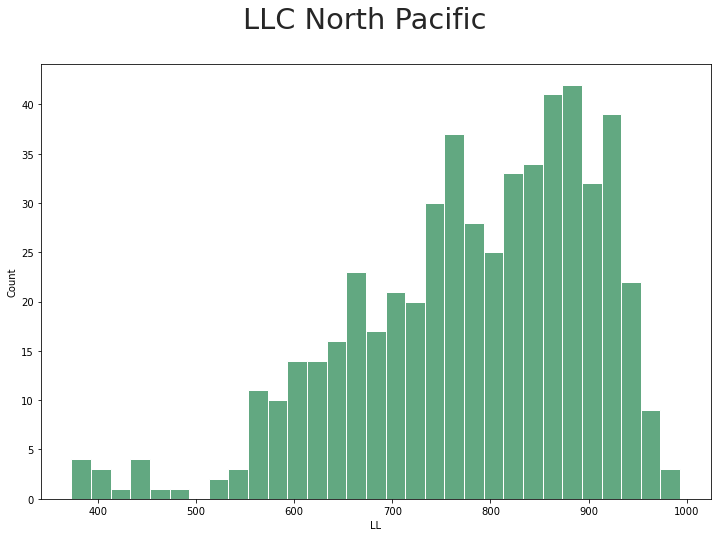

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)
ax = sns.histplot( data = llc_eqtr_n, x = 'LL', binwidth= 20, color = 'seagreen')

#ax.set_xlim(-800, 1000)
fig.suptitle('LLC North Pacific')
#ax.collections[0].colorbar.set_label("Num of Cutouts")

Text(0.5, 0.98, 'LLC North Pacific')

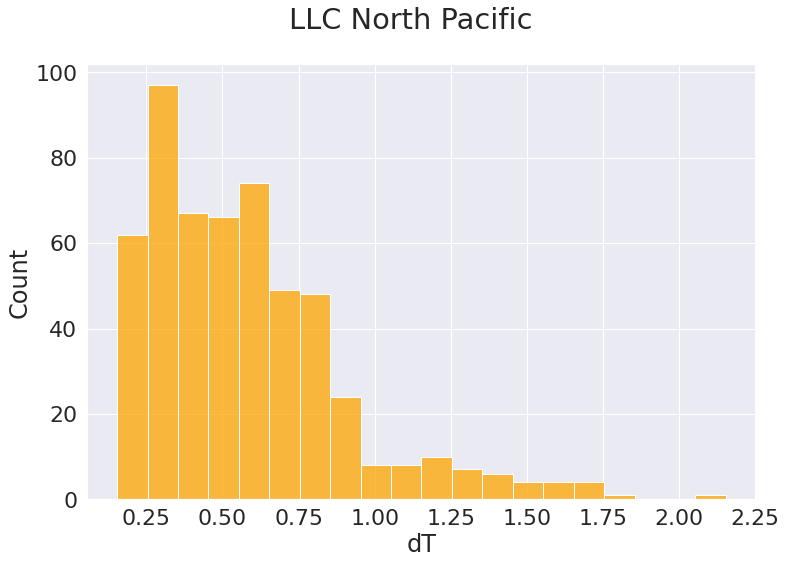

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)
ax = sns.histplot( data = llc_eqtr_n, x = 'dT', binwidth= 0.1, color = 'orange' )

#ax.set_xlim(-800, 1000)
fig.suptitle('LLC North Pacific')
#ax.collections[0].colorbar.set_label("Num of Cutouts")

### South : LLC

In [11]:
eqtr_s = (llc_tbl.lat < 0. ) & (np.abs(llc_tbl.lat) < 2.) & (np.abs(llc_tbl.lon + 100) < 5.)
llc_eqtr_s = llc_tbl[ eqtr_s ]

med_LL_s = np.median(llc_eqtr_s.LL.to_numpy())
med_LL_s

755.5679

In [12]:
uni_eqtr_s = uni_tbl[ eqtr_s ]

Text(0.5, 0.98, 'LLC South Pacific')

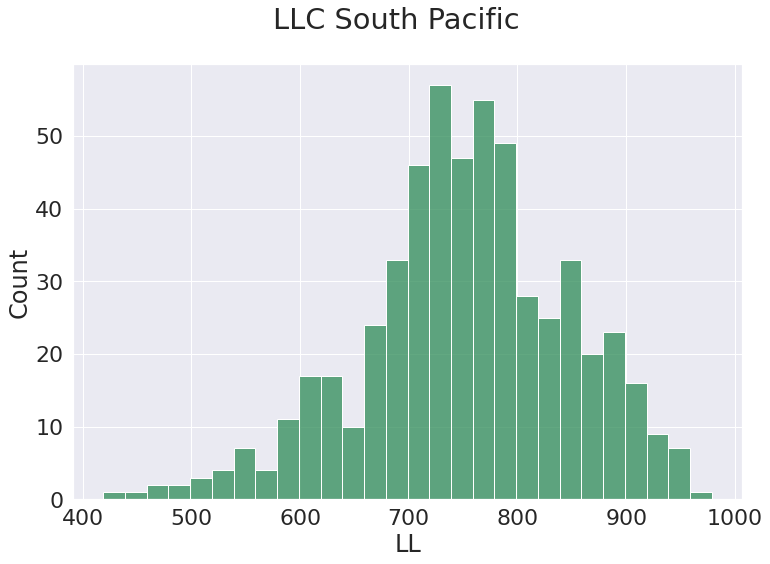

In [40]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)
ax = sns.histplot( data = llc_eqtr_s, x = 'LL', binwidth= 20, color = 'seagreen' )

#ax.set_xlim(-800, 1000)
fig.suptitle('LLC South Pacific')

Text(0.5, 0.98, 'LLC South Pacific')

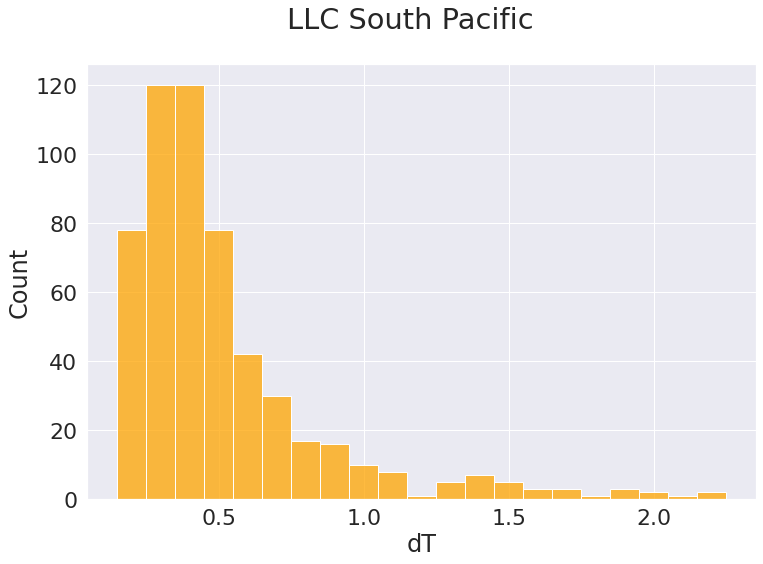

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)
ax = sns.histplot( data = llc_eqtr_s, x = 'dT', binwidth= 0.1, color = 'orange' )

#ax.set_xlim(-800, 1000)
fig.suptitle('LLC South Pacific')

In [10]:
med = np.abs(llc_tbl.LL - med_LL_n) > 10
llc_n = llc_tbl[ eqtr_n & med ]
llc_n

,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,T10,pp_idx,pp_type,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms,LL
50116,1.789456,-104.406250,7980,14060,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.969849,...,24.513000,719955,0,-0.603287,0.143694,0.124387,0.092743,0.853176,0.175910,821.077209
50118,1.789456,-103.010414,7980,14127,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.976315,...,24.546001,643809,0,-0.554783,0.140090,0.134385,0.087479,0.784582,0.190049,828.887207
50119,1.789456,-102.302086,7980,14161,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.943497,...,24.566002,101910,0,-0.542054,0.157311,0.145735,0.087732,0.766580,0.206101,814.885925
50120,1.789456,-101.593750,7980,14195,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.919466,...,24.575001,536627,0,-0.523959,0.168215,0.140864,0.091818,0.740990,0.199212,839.725464
50121,1.789456,-100.906250,7980,14228,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.902075,...,24.582001,12919,0,-0.505466,0.171128,0.134208,0.091033,0.714836,0.189799,868.678772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703753,0.009682,-103.718750,7888,14093,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,25.595280,...,25.311001,203254,0,-0.521753,0.125867,0.089974,0.062241,0.737870,0.127242,931.373047
703759,0.009682,-99.489586,7888,14296,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.876221,...,24.584000,508118,0,-0.507002,0.141368,0.082696,0.108962,0.717009,0.116949,856.292542
703760,0.009682,-98.781250,7888,14330,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.842934,...,24.587002,430919,0,-0.486798,0.186990,0.085530,0.105226,0.688437,0.120958,839.315125
703762,0.009682,-97.385414,7888,14397,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.801039,...,24.484001,508893,0,-0.404223,0.213044,0.099867,0.096209,0.571658,0.141234,828.237610


In [11]:
med = np.abs(llc_tbl.LL - med_LL_s) > 10
llc_s = llc_tbl[ eqtr_s & med ]
llc_s

,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,T10,pp_idx,pp_type,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms,LL
52367,-0.009682,-104.406250,7887,14060,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.054836,...,23.715000,316649,0,-0.679639,0.020223,0.140099,0.153966,0.961155,0.198129,732.616455
52369,-0.009682,-103.010414,7887,14127,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,23.980129,...,23.769001,585504,0,-0.751339,0.064553,0.120318,0.157427,1.062553,0.170155,855.597168
52370,-0.009682,-102.302086,7887,14161,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,23.849178,...,23.639999,584452,0,-0.767469,0.073366,0.122019,0.154935,1.085365,0.172561,903.554321
52371,-0.009682,-101.593750,7887,14195,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,23.790739,...,23.570000,81036,0,-0.756171,0.067403,0.134309,0.138631,1.069387,0.189941,899.021851
52373,-0.009682,-100.197914,7887,14262,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,23.666409,...,23.438000,106924,0,-0.741619,0.021388,0.098032,0.096933,1.048808,0.138639,880.158325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705950,-1.789456,-98.093750,7795,14363,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.122679,...,23.879002,109829,0,-0.425436,0.087076,0.068210,0.100249,0.601657,0.096464,875.103638
705951,-1.789456,-97.385414,7795,14397,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,24.077541,...,23.924999,647163,0,-0.413778,0.100955,0.081859,0.101755,0.585170,0.115766,911.038940
705952,-1.789456,-96.677086,7795,14431,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,23.889713,...,23.606001,3724,0,-0.419706,0.102430,0.092566,0.113807,0.593554,0.130909,821.453308
705953,-1.789456,-95.968750,7795,14465,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,23.672903,...,23.562000,611731,0,-0.433535,0.087049,0.093321,0.109049,0.613111,0.131975,849.615234


/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:842: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts

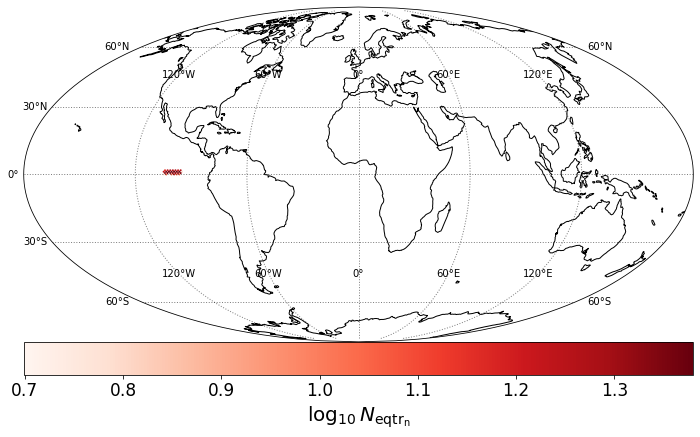

In [12]:
_ = ulmo_figs.show_spatial(llc_n, lbl = 'eqtr_n')

### North : VIIRS

In [13]:
eqtr_n = (viirs_tbl.lat > 0. ) & (np.abs(viirs_tbl.lat) < 2.) & (np.abs(viirs_tbl.lon + 100) < 5.)
viirs_eqtr_n = viirs_tbl[ eqtr_n ]

med_LL_n = np.median(viirs_eqtr_n.LL.to_numpy())
med_LL_n

437.59164

Text(0.5, 0.98, 'North Pacific')

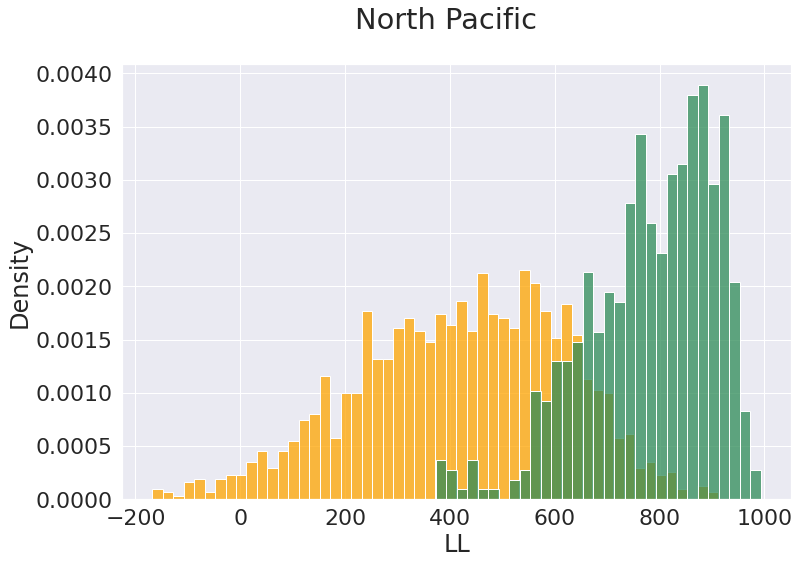

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)
ax = sns.histplot( data = viirs_eqtr_n, x = 'LL', binwidth= 20, color = 'orange', stat = 'density')
ax = sns.histplot( data = llc_eqtr_n, x = 'LL', binwidth= 20, color = 'seagreen', stat = 'density' )

#ax.set_xlim(-800, 1000)
fig.suptitle('North Pacific')

Text(0.5, 0.98, 'North Pacific')

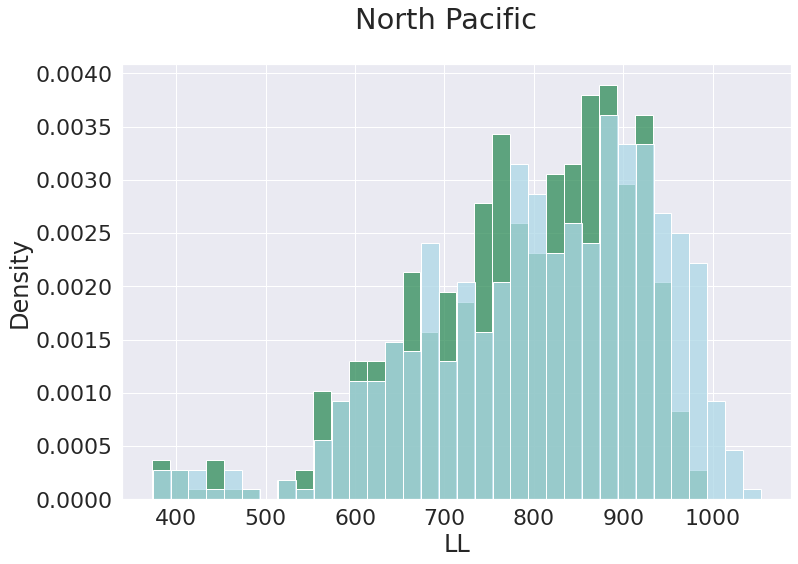

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)
ax = sns.histplot( data = llc_eqtr_n, x = 'LL', binwidth= 20, color = 'seagreen', stat = 'density')
ax = sns.histplot( data = uni_eqtr_n, x = 'LL', binwidth= 20, color = 'lightblue', stat = 'density' )

#ax.set_xlim(-800, 1000)
fig.suptitle('North Pacific')

Text(0.5, 0.98, 'North Pacific')

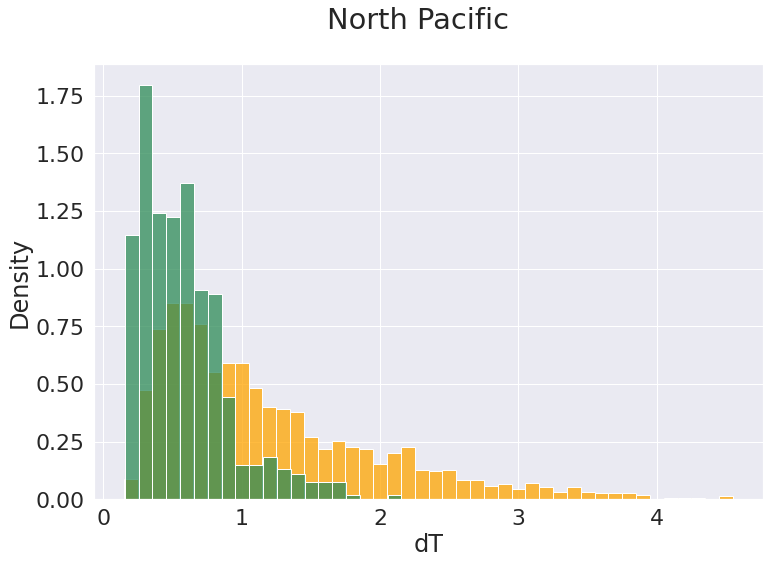

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)
ax = sns.histplot( data = viirs_eqtr_n, x = 'dT', binwidth= 0.1, color = 'orange', legend = 'VIIRS', stat = 'density')
ax = sns.histplot( data = llc_eqtr_n, x = 'dT', binwidth= 0.1, color = 'seagreen', legend = 'LLC', stat = 'density' )

#ax.set_xlim(-800, 1000)
fig.suptitle('North Pacific')

Text(0.5, 0.98, 'North Pacific')

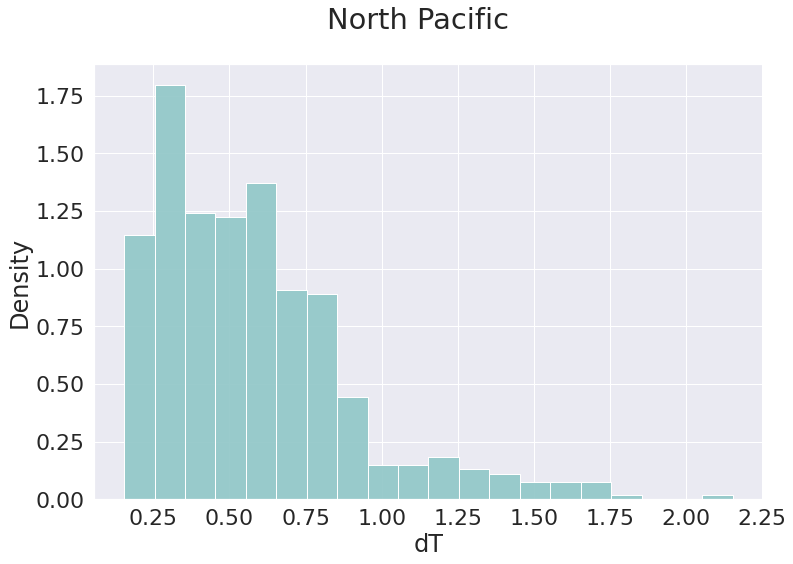

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)
ax = sns.histplot( data = llc_eqtr_n, x = 'dT', binwidth= 0.1, color = 'seagreen', legend = 'LLC', stat = 'density' )
ax = sns.histplot( data = uni_eqtr_n, x = 'dT', binwidth= 0.1, color = 'lightblue', legend = 'VIIRS', stat = 'density')

#ax.set_xlim(-800, 1000)
fig.suptitle('North Pacific')

### South : VIIRS

In [19]:
eqtr_s = (viirs_tbl.lat < 0. ) & (np.abs(viirs_tbl.lat) < 2.) & (np.abs(viirs_tbl.lon + 100) < 5.)
viirs_eqtr_s = viirs_tbl[ eqtr_s ]

med_LL_s = np.median(viirs_eqtr_s.LL.to_numpy())
med_LL_s

568.151

Text(0.5, 0.98, 'South Pacific')

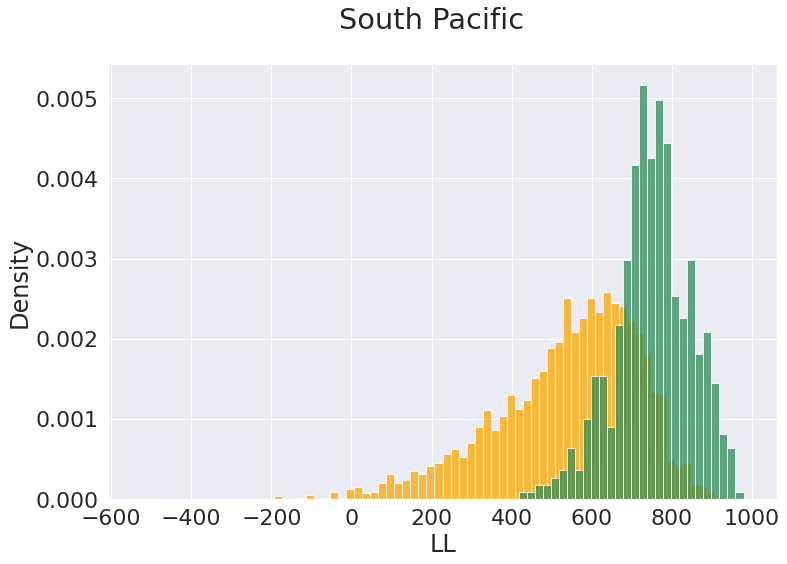

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)
ax = sns.histplot( data = viirs_eqtr_s, x = 'LL', binwidth= 20, color = 'orange', stat = 'density')
ax = sns.histplot( data = llc_eqtr_s, x = 'LL', binwidth= 20, color = 'seagreen', stat = 'density' )

#ax.set_xlim(-800, 1000)
fig.suptitle('South Pacific')

Text(0.5, 0.98, 'South Pacific')

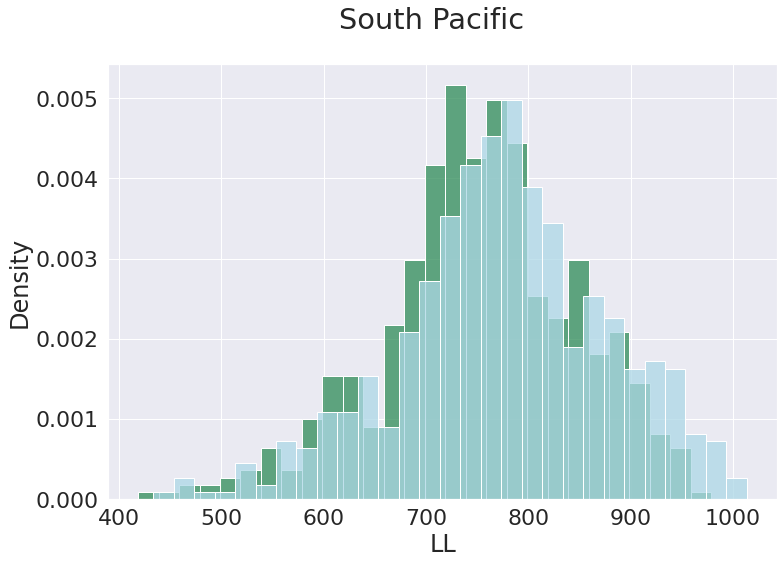

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)

ax = sns.histplot( data = llc_eqtr_s, x = 'LL', binwidth= 20, color = 'seagreen', stat = 'density' )
ax = sns.histplot( data = uni_eqtr_s, x = 'LL', binwidth= 20, color = 'lightblue', stat = 'density')

#ax.set_xlim(-800, 1000)
fig.suptitle('South Pacific')

Text(0.5, 0.98, 'South Pacific')

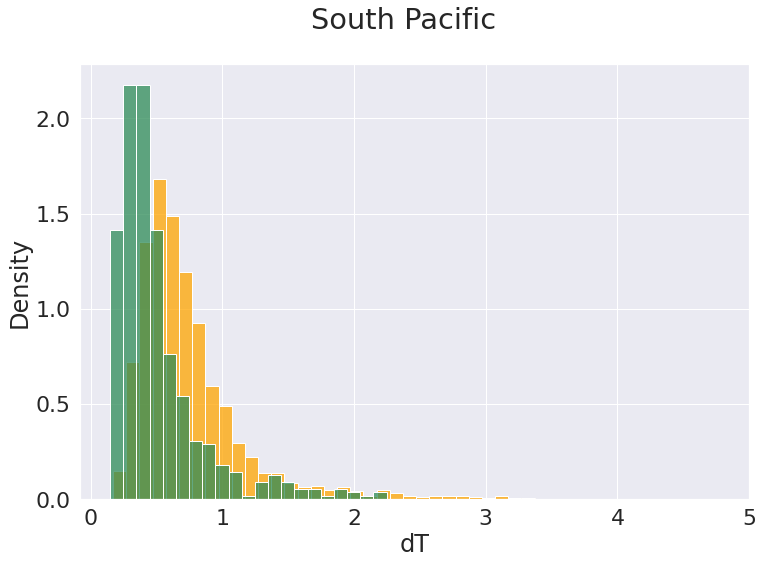

In [58]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)
ax = sns.histplot( data = viirs_eqtr_s, x = 'dT', binwidth= 0.1, color = 'orange', stat = 'density' )
ax = sns.histplot( data = llc_eqtr_s, x = 'dT', binwidth= 0.1, color = 'seagreen', stat = 'density' )

#ax.set_xlim(-800, 1000)
fig.suptitle('South Pacific')

In [15]:
med = np.abs(viirs_tbl.LL - med_LL_n) > 10
viirs_n = viirs_tbl[ eqtr_n & med ]
viirs_n

,filename,row,col,lat,lon,clear_fraction,field_size,datetime,ex_filename,pp_file,pp_root,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,LL,Year
14109,s3://viirs/data/2012/330/20121125075000-OSPO-L...,4080,1344,0.782293,-99.696270,-3.439993e-16,192,2012-11-25 07:50:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,60172,0,22.206514,20.089996,24.350006,22.489990,21.920013,263.351929,2012
21734,s3://viirs/data/2012/284/20121010071000-OSPO-L...,5199,384,0.361039,-98.279210,3.255208e-04,192,2012-10-10 07:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,92951,0,20.970110,20.029999,22.989990,22.220001,20.389984,389.811157,2012
24100,s3://viirs/data/2012/089/20120329191000-OSPO-L...,4560,2592,0.664930,-97.656370,4.964193e-03,192,2012-03-29 19:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,102592,0,27.723930,26.079987,28.619995,28.000000,27.410004,335.166504,2012
29856,s3://viirs/data/2012/284/20121010071000-OSPO-L...,5199,192,0.592288,-99.759150,5.072700e-03,192,2012-10-10 07:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,127272,0,20.688889,19.559998,22.399994,21.089996,20.420013,619.854431,2012
34754,s3://viirs/data/2012/305/20121031200000-OSPO-L...,3984,1920,0.110680,-104.272590,7.351345e-03,192,2012-10-31 20:00:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,148044,0,21.392933,19.639984,23.799988,21.889984,21.059998,293.434387,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287200,s3://viirs/data/2020/321/20201116074000-OSPO-L...,432,384,0.336902,-103.087685,2.848307e-03,192,2020-11-16 07:40:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,viirs_std,1130999,0,20.917160,18.630005,22.639984,21.940002,20.109985,370.379211,2020
2287333,s3://viirs/data/2020/094/20200403193000-OSPO-L...,4080,1920,0.448225,-96.463600,6.890191e-03,192,2020-04-03 19:30:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,viirs_std,1131531,0,27.547457,25.260010,28.230011,27.959991,26.899994,386.943481,2020
2289087,s3://viirs/data/2020/170/20200618191000-OSPO-L...,1200,2496,0.329386,-95.210884,7.866753e-04,192,2020-06-18 19:10:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,viirs_std,1139167,0,21.885956,21.269989,23.190002,22.089996,21.700012,557.060852,2020
2289474,s3://viirs/data/2020/344/20201209195000-OSPO-L...,144,2496,0.420977,-104.757520,3.185386e-16,192,2020-12-09 19:50:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,viirs_std,1140882,0,21.135202,20.429993,22.250000,21.619995,20.769989,497.651489,2020


/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:842: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts

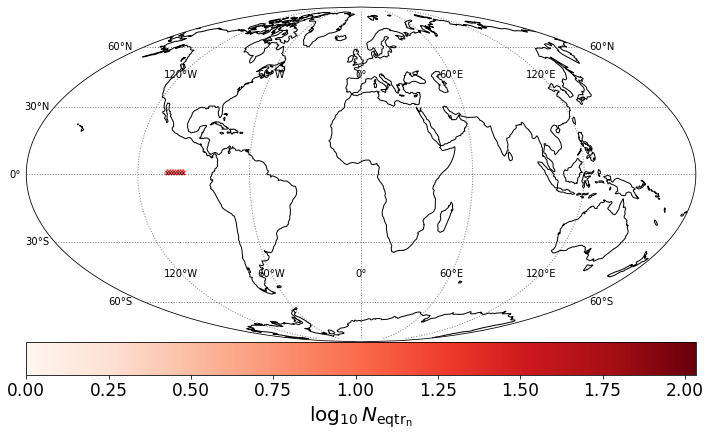

In [16]:
_ = ulmo_figs.show_spatial(viirs_n, lbl = 'eqtr_n')

In [17]:
med = np.abs(viirs_tbl.LL - med_LL_s) > 10
viirs_s = viirs_tbl[ eqtr_s & med ]
viirs_s

,filename,row,col,lat,lon,clear_fraction,field_size,datetime,ex_filename,pp_file,pp_root,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,LL,Year
1569,s3://viirs/data/2012/240/20120827074000-OSPO-L...,3024,576,-0.541198,-103.478040,2.441406e-04,192,2012-08-27 07:40:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,6933,0,20.896591,19.309998,21.359985,21.100006,20.690002,733.941040,2012
3414,s3://viirs/data/2012/345/20121210191000-OSPO-L...,3696,2784,-0.581065,-98.724174,5.886502e-03,192,2012-12-10 19:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,14671,0,22.752274,21.709991,23.160004,22.910004,22.570007,675.897339,2012
4249,s3://viirs/data/2012/119/20120428195000-OSPO-L...,3120,1920,-0.213072,-101.151460,8.463542e-03,192,2012-04-28 19:50:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,18240,0,26.291697,24.859985,27.779999,26.779999,25.869995,602.125977,2012
5079,s3://viirs/data/2012/196/20120714205000-OSPO-L...,720,96,-0.021713,-100.469604,4.934927e-17,192,2012-07-14 20:50:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,21631,0,24.445625,23.399994,26.369995,25.260010,23.790009,529.285583,2012
5310,s3://viirs/data/2012/196/20120714205000-OSPO-L...,624,192,-0.779451,-101.229090,-2.334649e-17,192,2012-07-14 20:50:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,22603,0,24.387127,23.589996,25.410004,24.709991,24.059998,614.043640,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288945,s3://viirs/data/2020/341/20201206080000-OSPO-L...,3216,1440,-1.112660,-100.954520,5.967882e-04,192,2020-12-06 08:00:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,viirs_std,1138588,0,20.772713,19.070007,21.720001,21.170013,20.369995,351.854492,2020
2289648,s3://viirs/data/2020/063/20200303191000-OSPO-L...,4560,2688,-0.459815,-97.998800,9.657118e-03,192,2020-03-03 19:10:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,viirs_std,1141573,0,26.096497,25.119995,27.660004,26.859985,25.670013,447.480225,2020
2290002,s3://viirs/data/2020/160/20200608075000-OSPO-L...,5040,1536,-0.082072,-98.456604,2.061632e-03,192,2020-06-08 07:50:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,viirs_std,1143106,0,21.999599,20.260010,22.899994,22.250000,21.739990,515.127136,2020
2290486,s3://viirs/data/2020/171/20200619203000-OSPO-L...,2064,672,-0.450734,-100.464570,6.320530e-03,192,2020-06-19 20:30:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,viirs_std,1145105,0,22.012575,21.570007,22.799988,22.399994,21.779999,681.405884,2020


/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:842: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts

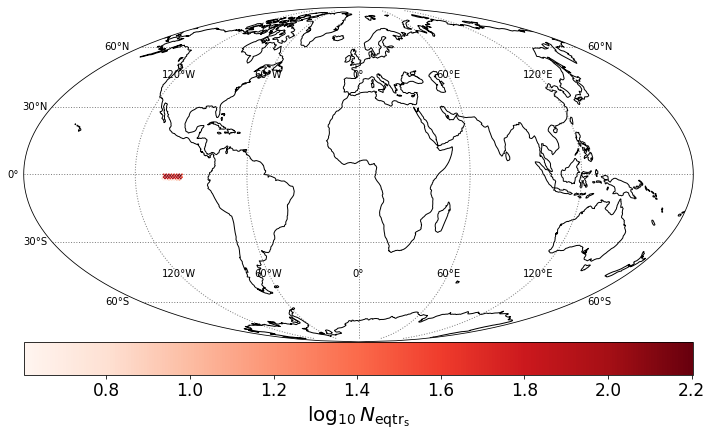

In [18]:
_ = ulmo_figs.show_spatial(viirs_s, lbl = 'eqtr_s')

# Region 2: 60W Shelf & Confluence

In [61]:
R2 = dict( lon=-61.0, dlon=1., lat=-45, dlat=2)
R1 = dict( lon=-56.5, dlon=1.5, lat=-45, dlat=2)

### R1 & R2 : LLC

In [62]:
in_R1, in_R2 = [((np.abs(llc_tbl.lon.values - R['lon']) < R['dlon']) & (np.abs(llc_tbl.lat.values - R['lat']) < R['dlat'])) for R in [R1, R2]]


#### R1

In [63]:
llc_R1 = llc_tbl[ in_R1 ]
med_LL1 = np.median(llc_R1.LL.to_numpy())
med_LL1

-24.417694

In [64]:
med = np.abs( llc_tbl.LL - med_LL1) > 10
llc1 = llc_tbl[ in_R1 & med ]
llc1

,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,pp_idx,pp_type,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms,LL,dT
104479,-43.011658,-57.239582,5404,16324,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,5.740609,...,697061,0,0.099146,0.136555,0.111945,0.088208,0.168041,0.128395,-36.599487,1.851
104480,-43.011658,-56.510418,5404,16359,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,6.387763,...,580546,0,0.078336,-0.056484,0.061880,0.200230,0.120102,0.074209,-334.251373,0.957
104481,-43.011658,-55.802082,5404,16393,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,8.682433,...,442309,0,-0.060814,-0.263229,0.184862,0.249355,0.209975,0.177919,-1155.327026,5.547
104482,-43.011658,-55.072918,5404,16428,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,10.968154,...,364969,0,-0.294348,-0.242054,0.297565,0.284214,0.464006,0.367519,-1181.357056,5.534
104954,-43.407059,-57.697918,5376,16302,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,5.903210,...,323979,0,0.041743,0.146651,0.088456,0.093631,0.101773,0.093680,-61.471863,1.699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760039,-46.566658,-57.031250,5146,16334,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,7.221001,...,238578,0,0.221759,-0.191676,0.069601,0.091930,0.313615,0.098431,-150.069580,1.417
760040,-46.566658,-56.239582,5146,16372,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,7.278836,...,476844,0,0.205491,-0.182698,0.070958,0.081004,0.290608,0.100350,-177.995544,1.954
760486,-46.967197,-57.531250,5116,16310,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,5.950093,...,516956,0,0.229512,-0.159963,0.098539,0.150085,0.324597,0.139313,-144.316711,3.196
760487,-46.967197,-56.739582,5116,16348,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,6.751180,...,737472,0,0.256858,-0.182316,0.075880,0.070537,0.363253,0.107311,-103.666077,1.504


#### R2

In [65]:
llc_R2 = llc_tbl[ in_R2 ]
med_LL2 = np.median(llc_R2.LL.to_numpy())
med_LL2

568.6373

In [66]:
med = np.abs( llc_tbl.LL - med_LL2) > 10
llc2 = llc_tbl[ in_R2 & med ]
llc2

,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,pp_idx,pp_type,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms,LL,dT
104473,-43.011658,-61.552082,5404,16117,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,7.529132,...,658954,0,-0.519319,0.398455,0.233740,0.228965,0.734428,0.330558,909.486755,0.498
104474,-43.011658,-60.843750,5404,16151,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,7.194749,...,589005,0,-0.421077,0.097121,0.163670,0.121978,0.595493,0.231465,796.714661,0.727
104475,-43.011658,-60.114582,5404,16186,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,6.719427,...,388913,0,-0.279638,-0.014939,0.125839,0.081298,0.402341,0.161825,744.250427,1.040
104949,-43.407059,-61.322918,5376,16128,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,7.226827,...,389765,0,-0.245162,0.222210,0.145363,0.149023,0.346768,0.205480,856.021484,0.779
104950,-43.407059,-60.614582,5376,16162,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,6.804779,...,604772,0,-0.221374,0.023946,0.111140,0.092406,0.314087,0.155133,797.773743,0.835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759587,-46.176937,-60.385418,5175,16173,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,5.148206,...,707757,0,0.228787,0.349284,0.061236,0.133310,0.323578,0.086507,429.833008,1.099
760033,-46.566658,-61.677082,5146,16111,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,5.075092,...,268525,0,0.312698,0.152398,0.061877,0.025995,0.442222,0.087507,757.433899,0.335
760034,-46.566658,-60.906250,5146,16148,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,5.301355,...,358022,0,0.303530,0.225564,0.089618,0.102501,0.429256,0.126739,556.713074,0.497
760035,-46.566658,-60.135418,5146,16185,2012-07-31,s3://llc/ThetaUVSalt/LLC4320_2012-07-31T00_00_...,s3://llc/PreProc/LLC_uniform_viirs_test_prepro...,llc_std,64,4.954287,...,593940,0,0.292793,0.369791,0.094441,0.112023,0.414071,0.133559,313.138123,1.173


### R1 & R2 : VIIRS

In [67]:
in_R1, in_R2 = [((np.abs(viirs_tbl.lon.values - R['lon']) < R['dlon']) & (np.abs(viirs_tbl.lat.values - R['lat']) < R['dlat'])) for R in [R1, R2]]

#### R1

In [68]:
viirs_R1 = viirs_tbl[ in_R1 ]
med_V1 = np.median( viirs_R1.LL.to_numpy())
med_V1

-118.96222

In [69]:
med = np.abs( viirs_tbl.LL - med_V1) > 10
viirs1 = viirs_tbl[ in_R1 & med]
viirs1

,filename,row,col,lat,lon,clear_fraction,field_size,datetime,ex_filename,pp_file,...,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,LL,Year,dT
66,s3://viirs/data/2012/144/20120523043000-OSPO-L...,2832,1536,-43.756165,-56.041350,6.808811e-03,192,2012-05-23 04:30:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,234,0,10.968087,8.940002,12.790009,11.489990,10.540009,45.188660,2012,0.949982
99,s3://viirs/data/2012/038/20120207042000-OSPO-L...,1872,1248,-44.712547,-56.173298,1.406025e-15,192,2012-02-07 04:20:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,396,0,16.678192,14.959991,18.279999,17.760010,15.730011,0.337830,2012,2.029999
449,s3://viirs/data/2012/328/20121123034000-OSPO-L...,2448,480,-43.873447,-56.247543,4.584418e-03,192,2012-11-23 03:40:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,1982,0,13.767694,11.859985,15.130005,14.209991,13.239990,208.195251,2012,0.970001
525,s3://viirs/data/2012/106/20120415044000-OSPO-L...,4464,1824,-43.662990,-56.219505,6.998698e-03,192,2012-04-15 04:40:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,2351,0,13.310152,10.959991,14.920013,13.940002,12.529999,-105.359497,2012,1.410004
671,s3://viirs/data/2012/281/20121007172000-OSPO-L...,1008,1920,-45.840477,-55.295174,9.087457e-03,192,2012-10-07 17:20:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,2952,0,9.313038,8.029999,10.779999,10.010010,8.600006,-62.502380,2012,1.410004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289778,s3://viirs/data/2020/267/20200923183000-OSPO-L...,5136,384,-45.809753,-55.689026,-1.488474e-16,192,2020-09-23 18:30:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,...,1142097,0,8.306816,6.299988,10.600006,9.459991,7.290009,-375.913361,2020,2.169983
2289859,s3://viirs/data/2020/293/20201019171000-OSPO-L...,1008,2304,-45.069370,-57.243240,4.611545e-04,192,2020-10-19 17:10:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,...,1142502,0,8.207664,5.190002,9.649994,9.079987,6.839996,-22.638428,2020,2.239990
2289893,s3://viirs/data/2020/105/20200414034000-OSPO-L...,240,480,-45.601450,-55.769970,8.138021e-05,192,2020-04-14 03:40:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,...,1142649,0,13.711468,12.630005,15.410004,14.230011,13.230011,139.667236,2020,1.000000
2289979,s3://viirs/data/2020/105/20200414034000-OSPO-L...,336,384,-45.928960,-57.011330,6.239149e-03,192,2020-04-14 03:40:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,...,1142999,0,13.283173,10.019989,14.589996,13.880005,11.920013,-14.745972,2020,1.959991


#### R2

In [70]:
viirs_R2 = viirs_tbl[ in_R2 ]
med_V2 = np.median( viirs_R2.LL.to_numpy())
med_V2

259.34436

In [71]:
med = np.abs( viirs_tbl.LL - med_V2) > 10
viirs2 = viirs_tbl[ in_R2 & med]
viirs2

,filename,row,col,lat,lon,clear_fraction,field_size,datetime,ex_filename,pp_file,...,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,LL,Year,dT
48,s3://viirs/data/2012/276/20121002185000-OSPO-L...,3696,384,-43.364735,-61.983430,2.220988e-16,192,2012-10-02 18:50:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,184,0,10.266752,8.839996,11.760010,11.029999,9.440002,380.855591,2012,1.589996
202,s3://viirs/data/2012/063/20120303185000-OSPO-L...,912,480,-44.883175,-60.572170,-2.721257e-16,192,2012-03-03 18:50:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,849,0,16.145388,11.779999,18.910004,17.959991,14.029999,-69.495728,2012,3.929993
233,s3://viirs/data/2012/339/20121204173000-OSPO-L...,3024,2112,-43.424538,-61.731606,-7.988582e-16,192,2012-12-04 17:30:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,994,0,14.387413,12.109985,15.619995,15.269989,13.440002,516.916260,2012,1.829987
437,s3://viirs/data/2012/123/20120502043000-OSPO-L...,48,1056,-45.887980,-60.771538,5.628093e-16,192,2012-05-02 04:30:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,1922,0,10.096664,6.769989,12.000000,11.440002,8.450012,102.662170,2012,2.989990
502,s3://viirs/data/2012/280/20121006174000-OSPO-L...,528,2016,-45.659004,-61.373955,1.057943e-03,192,2012-10-06 17:40:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,...,2238,0,8.229064,5.130005,9.170013,8.679993,7.820007,535.727417,2012,0.859985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2290551,s3://viirs/data/2020/054/20200223043000-OSPO-L...,3312,1056,-43.075450,-60.929073,5.425347e-05,192,2020-02-23 04:30:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,...,1145441,0,16.193348,13.160004,17.779999,17.559998,14.720001,246.331299,2020,2.839996
2290654,s3://viirs/data/2020/099/20200408035000-OSPO-L...,1776,384,-45.927982,-60.182465,8.782851e-16,192,2020-04-08 03:50:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,...,1145871,0,11.368928,8.760010,14.049988,12.790009,9.730011,40.726624,2020,3.059998
2290922,s3://viirs/data/2020/293/20201019185000-OSPO-L...,1488,384,-43.505306,-60.415770,-9.767758e-17,192,2020-10-19 18:50:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,...,1146984,0,8.972279,6.869995,10.329987,9.769989,7.980011,426.669189,2020,1.789978
2291438,s3://viirs/data/2020/077/20200317180000-OSPO-L...,1008,1536,-45.384262,-60.771880,2.712674e-05,192,2020-03-17 18:00:00,s3://viirs/Extractions/VIIRS_2020_95clear_192x...,s3://viirs/PreProc/VIIRS_2020_95clear_192x192_...,...,1149278,0,13.495462,10.889984,15.170013,14.730011,12.100006,195.857239,2020,2.630005


/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:842: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts

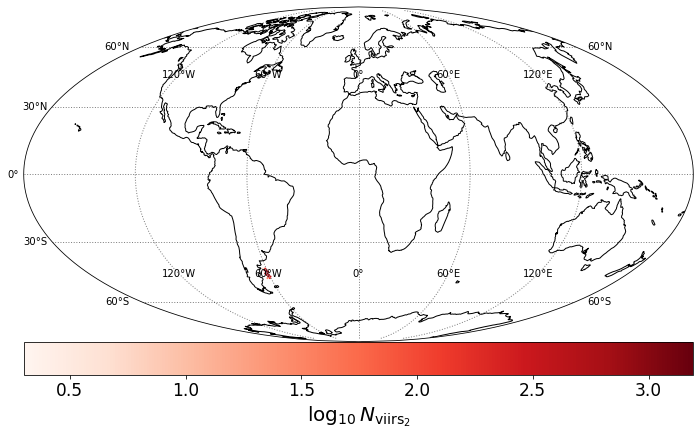

In [33]:
_ = ulmo_figs.show_spatial(viirs2, lbl = 'viirs_2')

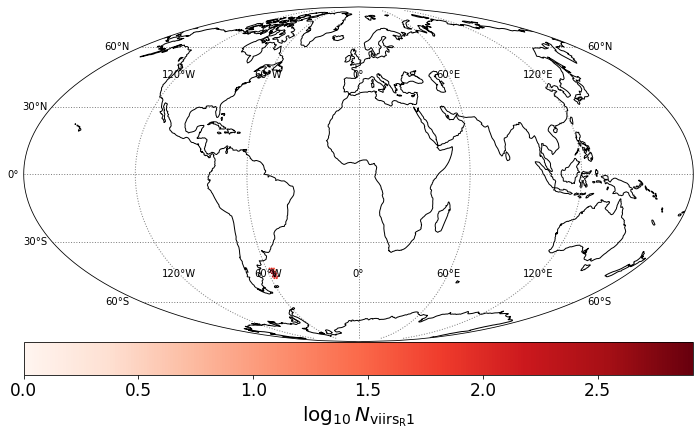

In [34]:
_ = ulmo_figs.show_spatial(viirs1, lbl = 'viirs_R1')

Text(0.5, 0.98, '60W R1')

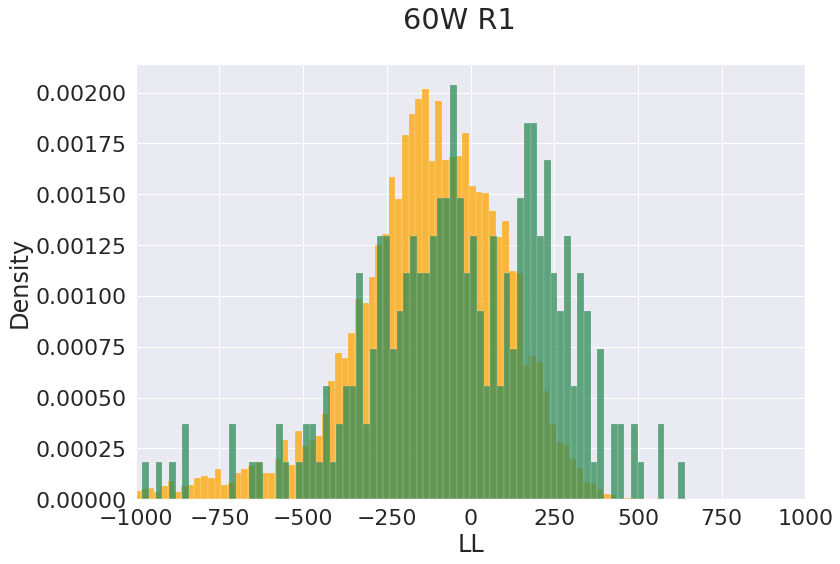

In [74]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)
ax = sns.histplot( data = viirs_R1, x = 'LL', binwidth= 20, color = 'orange', stat = 'density')
ax = sns.histplot( data = llc_R1, x = 'LL', binwidth= 20, color = 'seagreen', stat = 'density' )

ax.set_xlim(-1000, 1000)
fig.suptitle('60W R1')

Text(0.5, 0.98, '60W R1')

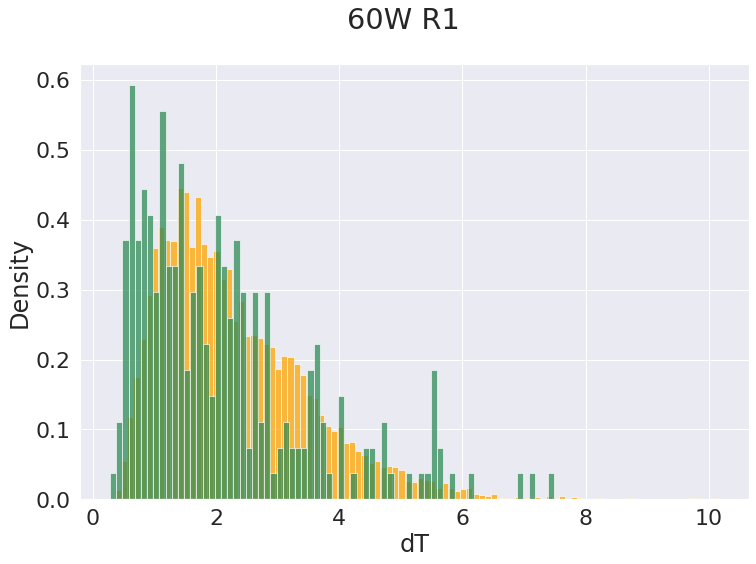

In [77]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)
ax = sns.histplot( data = viirs_R1, x = 'dT', binwidth= 0.1, color = 'orange', stat = 'density')
ax = sns.histplot( data = llc_R1, x = 'dT', binwidth= 0.1, color = 'seagreen', stat = 'density' )

#ax.set_xlim(-800, 1000)
fig.suptitle('60W R1')

Text(0.5, 0.98, '60W R2')

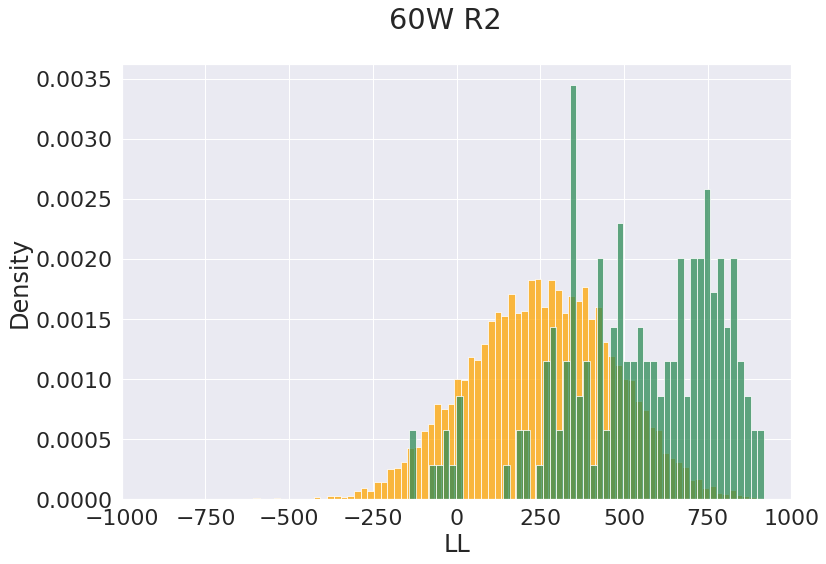

In [78]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)
ax = sns.histplot( data = viirs_R2, x = 'LL', binwidth= 20, color = 'orange', stat = 'density')
ax = sns.histplot( data = llc_R2, x = 'LL', binwidth= 20, color = 'seagreen', stat = 'density' )

ax.set_xlim(-1000, 1000)
fig.suptitle('60W R2')

Text(0.5, 0.98, '60W R2')

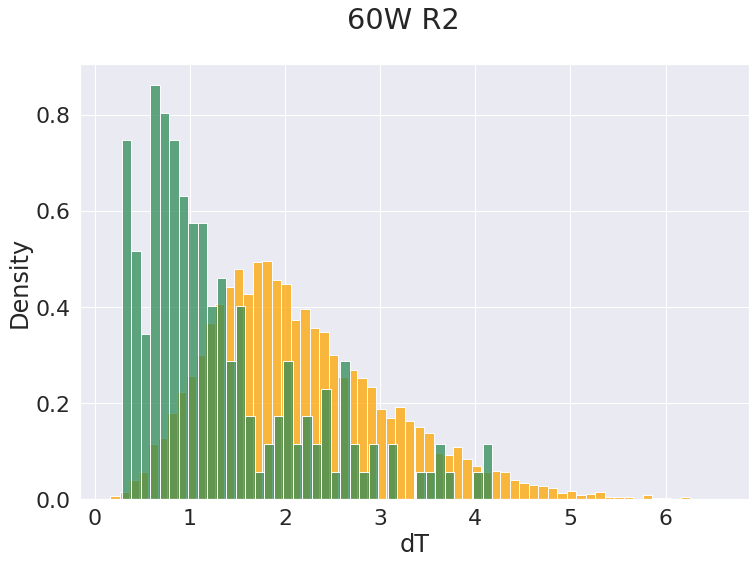

In [79]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.set(font_scale = 2)
ax = sns.histplot( data = viirs_R2, x = 'dT', binwidth= 0.1, color = 'orange', stat = 'density')
ax = sns.histplot( data = llc_R2, x = 'dT', binwidth= 0.1, color = 'seagreen', stat = 'density' )

#ax.set_xlim(-800, 1000)
fig.suptitle('60W R2')

# ~ Med LL 9 image gallery

In [41]:
pal, cm = plotting.load_palette()

### Equatorial Pacific: LLC

In [79]:
#Generate 9 random numbers from tbl
northlist = np.random.choice( llc_n.index.to_numpy(), size = 9)
print(northlist)

[443199 572735 441339 571231 310677 180790 181159  50510 573108]


In [36]:
cutout = llc_tbl.iloc[50510]

In [37]:
cutout

lat                                                          1.499536
lon                                                        -97.739586
row                                                              7965
col                                                             14380
datetime                                          2011-09-30 00:00:00
LLC_file            s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...
pp_file             s3://llc/PreProc/LLC_uniform_viirs_test_prepro...
pp_root                                                       llc_std
field_size                                                         64
mean_temperature                                            24.579155
Tmin                                                           23.642
Tmax                                                           25.211
T90                                                         25.088001
T10                                                         23.868999
pp_idx              

In [38]:
img= llc_io.grab_image(cutout)

Text(0.5, 1.0, '1')

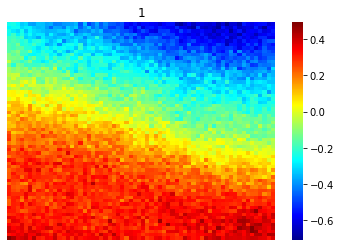

In [42]:
ax = sns.heatmap(img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
ax.set_title('1')

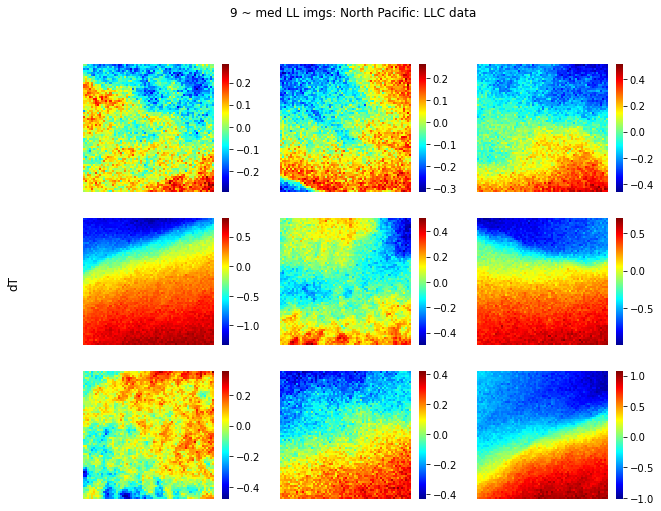

In [80]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ med LL imgs: North Pacific: LLC data')
fig.supylabel('dT')

for i in [0, 1, 2]: 
    
    idx = northlist[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = northlist[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = northlist[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
#plt.show()
plt.savefig( 'medLL9_LLC_NP', dpi = 600)

In [81]:
#Generate 9 random numbers from tbl
southlist = np.random.choice( llc_s.index.to_numpy(), size = 9)
print(southlist)

[575312 445387  54569  53851 704871 183395 703758  53124 313294]


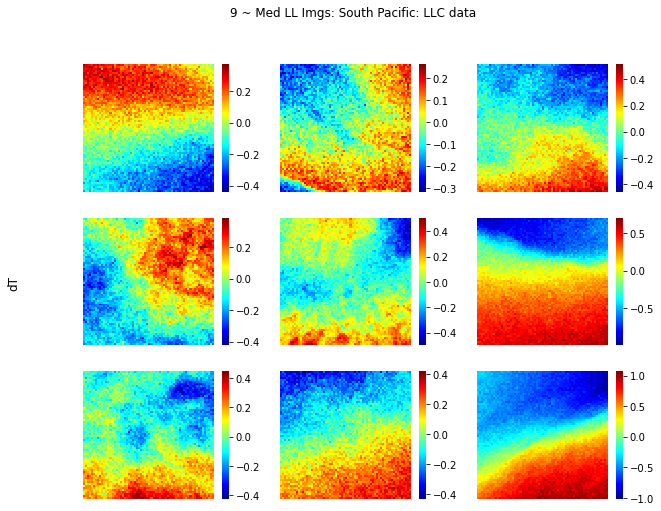

In [82]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ Med LL Imgs: South Pacific: LLC data')
fig.supylabel( 'dT' )

for i in [0, 1, 2]: 
    
    idx = southlist[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = northlist[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = northlist[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
#plt.show()
plt.savefig( 'medLL9_LLC_SP', dpi = 600)

### Equatorial Pacific: VIIRS

In [83]:
#Generate 9 random numbers from tbl
northlist = np.random.choice( viirs_n.index.to_numpy(), size = 9)
print(northlist)

[2170106 1317644 2112796 1618114 1084317 1960843 1392441 1752990  824701]


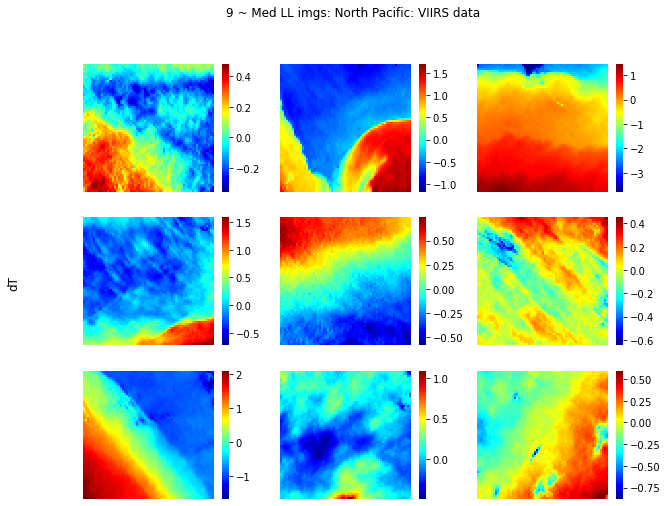

In [84]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ Med LL imgs: North Pacific: VIIRS data')
fig.supylabel('dT')

for i in [0, 1, 2]: 
    
    idx = northlist[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = northlist[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = northlist[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
#plt.show()
plt.savefig( 'medLL9_VIIRS_NP', dpi = 600)

In [85]:
#Generate 9 random numbers from tbl
southlist = np.random.choice( viirs_s.index.to_numpy(), size = 9)
print(southlist)

[ 990278 1558771 1883559 1226232  729305 1158107 1153394  740369 2159950]


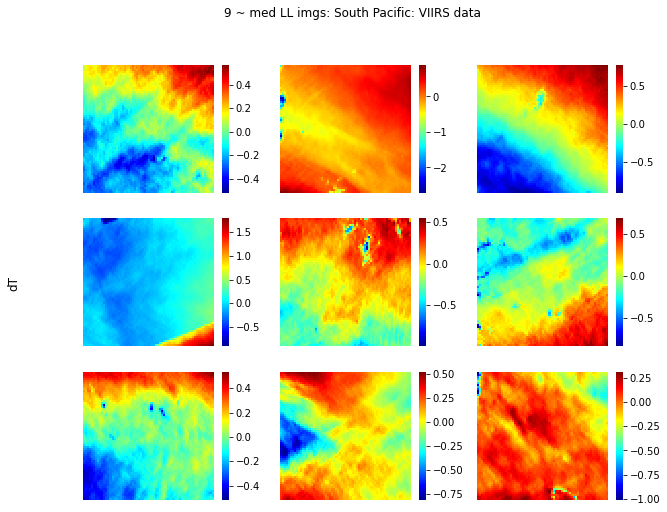

In [86]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ med LL imgs: South Pacific: VIIRS data')
fig.supylabel('dT')

for i in [0, 1, 2]: 
    
    idx = southlist[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = southlist[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = southlist[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
#plt.show()
plt.savefig( 'medLL9_VIIRS_SP', dpi = 600)

### 60W : LLC

In [87]:
R1list = np.random.choice( llc1.index.to_numpy(), size = 9)
print(R1list)

[627939 499487 627940 499037 365511 495786 499487 627474 629762]


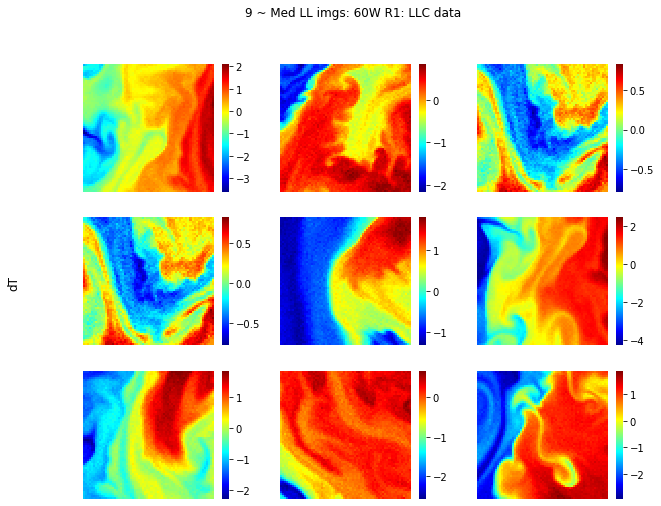

In [88]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ Med LL imgs: 60W R1: LLC data')
fig.supylabel('dT')

for i in [0, 1, 2]: 
    
    idx = R1list[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = R1list[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = R1list[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
#plt.show()
plt.savefig( 'medLL9_LLC_60W_R1', dpi = 600)

In [92]:
R2list = np.random.choice( llc2.index.to_numpy(), size = 9)
print(R2list)

[107287 757280 369204 756334 495304 757746 499479 760034 626058]


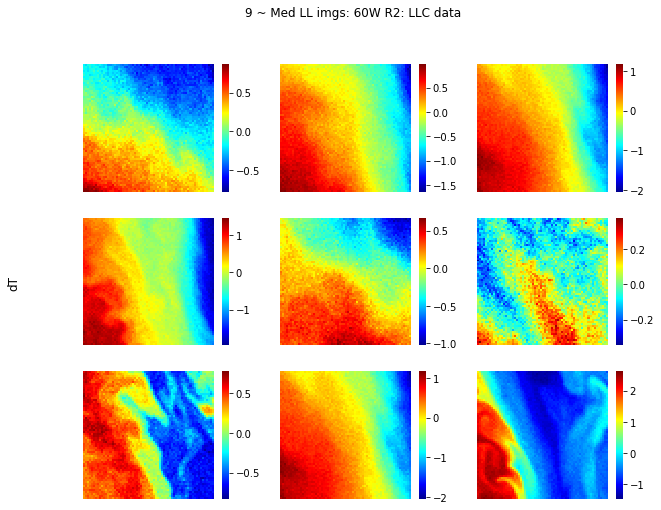

In [91]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ Med LL imgs: 60W R2: LLC data')
fig.supylabel('dT')

for i in [0, 1, 2]: 
    
    idx = R2list[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = R2list[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = R2list[ i ] 
    cutout = llc_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
#plt.show()
plt.savefig( 'medLL9_LLC_60W_R2', dpi = 600)

### 60W : VIIRS

In [93]:
R1list = np.random.choice( viirs1.index.to_numpy(), size = 9)
print(R1list)

[1986523  335402 1490789 1686908 1084842  510356 1620133 1806211 1204607]


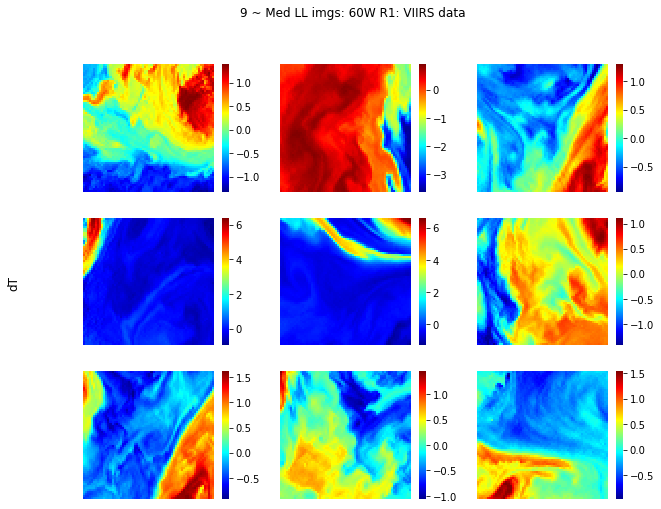

In [94]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ Med LL imgs: 60W R1: VIIRS data')
fig.supylabel('dT')

for i in [0, 1, 2]: 
    
    idx = R1list[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = R1list[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = R1list[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
#plt.show()
plt.savefig( 'medLL9_VIIRS_60W_R1', dpi = 600)

In [95]:
R2list = np.random.choice( viirs2.index.to_numpy(), size = 9)
print(R2list)

[1310267  273546 1264267  729971  640231  166573  779857  997641  864394]


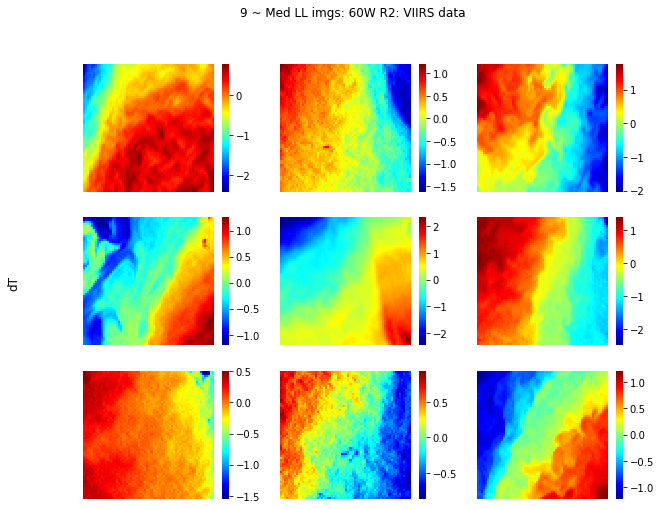

In [96]:
fig, axes = plt.subplots(3, 3, figsize = (10,8) )

fig.suptitle('9 ~ Med LL imgs: 60W R2: VIIRS data')
fig.supylabel('dT')

for i in [0, 1, 2]: 
    
    idx = R2list[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax=axes[i, 0], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [3, 4, 5]: 
    
    idx = R2list[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-3, 1], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)
    
for i in [6, 7, 8]: 
    
    idx = R2list[ i ] 
    cutout = viirs_tbl.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    sns.heatmap(ax = axes[i-6, 2], data=img, xticklabels=[], yticklabels=[], cmap=cm,
             cbar=True)  
#plt.show()
plt.savefig( 'medLL9_LLC_60W_R2', dpi = 600)